In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import utils_meteo
from datasets import load_dataset
from datetime import timedelta
from chronos import ChronosPipeline
from darts import TimeSeries
from darts.dataprocessing.pipeline import Pipeline
from darts.models import TiDEModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import StaticCovariatesTransformer, MissingValuesFiller
from huggingface_hub import hf_hub_download

TIME_COL = "date"
TARGET = "hu"
STATIC_COV = ["number_sta"]
DYNAMIC_COV = ['CPI', 'Inflation_Rate', 'GDP']
FREQ = "D"
FORECAST_HORIZON = 10 # months
SCALER = Scaler()
TRANSFORMER = StaticCovariatesTransformer()
PIPELINE = Pipeline([SCALER, TRANSFORMER])

/home/hadrakey/.conda/envs/chronos/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [49]:
# load data and exogenous features
path = "/mnt/data1/Datasets/Multimodal_v2/ts-data/french_weather/"
df = pd.read_csv(path + "every6m-data2018.csv")
# df = pd.DataFrame(load_dataset("zaai-ai/time_series_datasets", data_files={'train': 'data.csv'})['train']).drop(columns=['Unnamed: 0'])
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

print(f"Distinct number of time series: {len(df['number_sta'].unique())}")
df.head()

Distinct number of time series: 545


,date,number_sta,dd,ff,precip,hu,td,t,psl
0,2018-01-01,1027003,NaN,NaN,NaN,90.0,279.15,280.65,NaN
1,2018-01-01,1033002,30.0,2.7,0.2,89.0,277.65,279.35,NaN
2,2018-01-01,1034004,190.0,1.4,0.0,86.0,278.25,280.45,NaN
3,2018-01-01,1072001,NaN,NaN,0.0,NaN,NaN,280.25,NaN
4,2018-01-01,1089001,130.0,1.3,0.0,94.0,279.75,280.65,101760.0


In [29]:
def load_meteo_data(path,filename):
    df = pd.read_csv(path + filename)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    meteo_index = df.set_index("date")
    meteo_index['hu'].interpolate(method='time', inplace=True)
    meteo = meteo_index.groupby("number_sta", as_index=False).resample("D").mean()
    data=meteo.reset_index()[["date", "number_sta", "hu"]]
    return data

In [30]:
meteo_data = []
path = "/mnt/data1/Datasets/Multimodal_v2/ts-data/french_weather/"
for dat in [2018]:
    filename = "every6m-data" + str(dat) + ".csv"
    df = load_meteo_data(path,filename)
    meteo_data.append(df)

In [31]:
df = pd.concat(meteo_data, ignore_index=True)

In [32]:
df.head()

,date,number_sta,hu
0,2018-01-01,1027003.0,80.679167
1,2018-01-02,1027003.0,77.058333
2,2018-01-03,1027003.0,80.033333
3,2018-01-04,1027003.0,93.241667
4,2018-01-05,1027003.0,82.687500


Filter short time series

In [10]:
df["count"] = df.groupby("number_sta")['number_sta'].transform('count')

In [11]:
df.head()

,date,number_sta,hu,count
0,2018-01-01,1027003.0,80.679167,365.0
1,2018-01-02,1027003.0,77.058333,365.0
2,2018-01-03,1027003.0,80.033333,365.0
3,2018-01-04,1027003.0,93.241667,365.0
4,2018-01-05,1027003.0,82.687500,365.0


In [12]:
data = df.query("count == 365")
# data.rename(columns={"number_sta" : "unique_id"}, inplace=True)

In [13]:
data.head()

,date,number_sta,hu,count
0,2018-01-01,1027003.0,80.679167,365.0
1,2018-01-02,1027003.0,77.058333,365.0
2,2018-01-03,1027003.0,80.033333,365.0
3,2018-01-04,1027003.0,93.241667,365.0
4,2018-01-05,1027003.0,82.687500,365.0


In [16]:
df=data[["date", "number_sta", "hu"]]

In [11]:
df.shape

(125560, 3)

In [12]:
df["number_sta"].unique()

array([ 1027003.,  1033002.,  1034004.,  1072001.,  1089001.,  1414001.,
        3060001.,  3061001.,  3248001.,  4019001.,  4070009.,  4115001.,
        4126001.,  4134002.,  4136001.,  4209005.,  4230001.,  5007003.,
        5046001.,  5055001.,  5061009.,  5070003.,  5120002.,  5126001.,
        5136002.,  5145002.,  5170001.,  5183001.,  6004002.,  6004009.,
        6005001.,  6023004.,  6029001.,  6033002.,  6038001.,  6050002.,
        6059003.,  6074005.,  6075007.,  6077006.,  6081001.,  6083005.,
        6088001.,  6088007.,  6094002.,  6099004.,  6102001.,  6118002.,
        6120004.,  6127006.,  6136005.,  6152002.,  6163007.,  7019005.,
        7032002.,  7064001.,  7069001.,  7096001.,  7105003.,  7131001.,
        7161001.,  7185001.,  7187001.,  7204008.,  7294001., 11069001.,
       11124003., 11136001., 11168001., 11181002., 11202001., 11203004.,
       11221004., 11260002., 11262005., 11333001., 11412001., 12005001.,
       12050001., 12063003., 12077002., 12092001., 

In [13]:
df["number_sta"]= df["number_sta"].astype(str)

/tmp/ipykernel_4132138/726696437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["number_sta"]= df["number_sta"].astype(str)


In [8]:
max(df[TIME_COL])-pd.DateOffset(minutes=FORECAST_HORIZON)

Timestamp('2016-12-31 22:14:00')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1644 entries, 1830 to 147564
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1644 non-null   datetime64[ns]
 1   number_sta  1644 non-null   object        
 2   t           1643 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 51.4+ KB


# Split data between train and test

In [17]:
# 8 months to test
train = df[df[TIME_COL] <= (max(df[TIME_COL])-pd.DateOffset(days=FORECAST_HORIZON))]
test = df[df[TIME_COL] > (max(df[TIME_COL])-pd.DateOffset(days=FORECAST_HORIZON))]

# read train and test datasets and transform train dataset
train_darts = TimeSeries.from_group_dataframe(
      df=train,
      group_cols=STATIC_COV,
      time_col=TIME_COL,
      value_cols=TARGET,
      freq=FREQ,  
      fill_missing_dates=True,
      fillna_value=0)

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Months for training: {len(train[TIME_COL].unique())} from {min(train[TIME_COL]).date()} to {max(train[TIME_COL]).date()}")
print(f"Months for testing: {len(test[TIME_COL].unique())} from {min(test[TIME_COL]).date()} to {max(test[TIME_COL]).date()}")

Months for training: 355 from 2018-01-01 to 2018-12-21
Months for testing: 10 from 2018-12-22 to 2018-12-31


# Forecast

## TiDE

In [18]:


# scale data and transform static covariates
data_transformed = PIPELINE.fit_transform(train_darts)

TiDE_params = {
    "input_chunk_length": 5, # number of months to lookback
    "output_chunk_length": FORECAST_HORIZON,
    "num_encoder_layers": 2,
    "num_decoder_layers": 2,
    "decoder_output_dim": 1,
    "hidden_size": 15,
    "temporal_width_past": 4,
    "temporal_width_future": 4,
    "temporal_decoder_hidden": 26,
    "dropout": 0.1,
    "batch_size": 16,
    "n_epochs": 15,
    "likelihood": QuantileRegression(quantiles=[0.25, 0.5, 0.75]),
    "random_state": 42,
    "use_static_covariates": True,
    "optimizer_kwargs": {"lr": 1e-3},
    "use_reversible_instance_norm": False,
}

model = TiDEModel(**TiDE_params)
model.fit(data_transformed, verbose=False)
pred = PIPELINE.inverse_transform(model.predict(n=FORECAST_HORIZON, series=data_transformed, num_samples=50))
tide_forecast = utils_meteo.transform_predictions_to_pandas(pred, TARGET, train_darts, [0.25, 0.5, 0.75])

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3,4]
`Trainer.fit` stopped: `max_epochs=15` reached.
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2,3

Predicting DataLoader 0: 100%|██████████████████████████| 22/22 [00:01<00:00, 12.68it/s]


In [15]:
tide_forecast

,date,forecast,forecast_lower,forecast_upper,unique_id
0,2018-12-22,282.107392,280.311441,282.886705,1027003.0
1,2018-12-23,281.193371,279.861491,283.509722,1027003.0
2,2018-12-24,281.866988,279.237683,283.209463,1027003.0
3,2018-12-25,280.562250,278.693033,283.320530,1027003.0
4,2018-12-26,281.063730,279.279795,283.431665,1027003.0
...,...,...,...,...,...
5,2018-12-27,277.172845,274.848613,280.596923,84150001.0
6,2018-12-28,279.499123,276.827258,282.201059,84150001.0
7,2018-12-29,279.628488,277.040407,282.623457,84150001.0
8,2018-12-30,280.334206,276.895237,282.822437,84150001.0


## Chronos

In [19]:
import warnings
warnings.filterwarnings('ignore')
# load model
pipeline_tiny = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

pipeline_large = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

# run forecast
forecast_tiny = []
forecast_large = []
for ts in train_darts:
    # tiny
    lower, mid, upper = utils_meteo.chronos_forecast(pipeline_tiny, ts.pd_dataframe().reset_index(), FORECAST_HORIZON, TARGET)
    forecast_tiny.append(utils_meteo.convert_forecast_to_pandas([lower, mid, upper], test[test['number_sta'] == list(ts.static_covariates_values())[0][0]]))
    
    # large
    lower, mid, upper = utils_meteo.chronos_forecast(pipeline_large, ts.pd_dataframe().reset_index(), FORECAST_HORIZON, TARGET)
    forecast_large.append(utils_meteo.convert_forecast_to_pandas([lower, mid, upper], test[test['number_sta'] == list(ts.static_covariates_values())[0][0]]))

# convert list to data frames
forecast_tiny = pd.concat(forecast_tiny)
forecast_large = pd.concat(forecast_large)

In [41]:
test[test['number_sta'] == list(ts.static_covariates_values())[0][0]]

,date,number_sta,t
2092,2016-09-19,1185004.0,285.183333
2093,2016-09-20,1185004.0,284.056250
2094,2016-09-21,1185004.0,282.810000


In [46]:
test[test['number_sta'] == 1384003.]

,date,number_sta,t
3094,2016-09-24,1384003.0,285.825000
3095,2016-09-25,1384003.0,289.816667
3096,2016-09-26,1384003.0,288.672917
3097,2016-09-27,1384003.0,288.502083
3098,2016-09-28,1384003.0,283.283333


In [44]:
test['number_sta'].unique()

array([1185004., 1384003.])

## Plot Actuals and Forecast

In [20]:
test.rename(columns={"number_sta" : "unique_id"}, inplace=True)

In [21]:
df.rename(columns={"number_sta" : "unique_id"}, inplace=True)

In [22]:
forecast_tiny.rename(columns={"number_sta" : "unique_id"}, inplace=True)

In [23]:
forecast_large.rename(columns={"number_sta" : "unique_id"}, inplace=True)

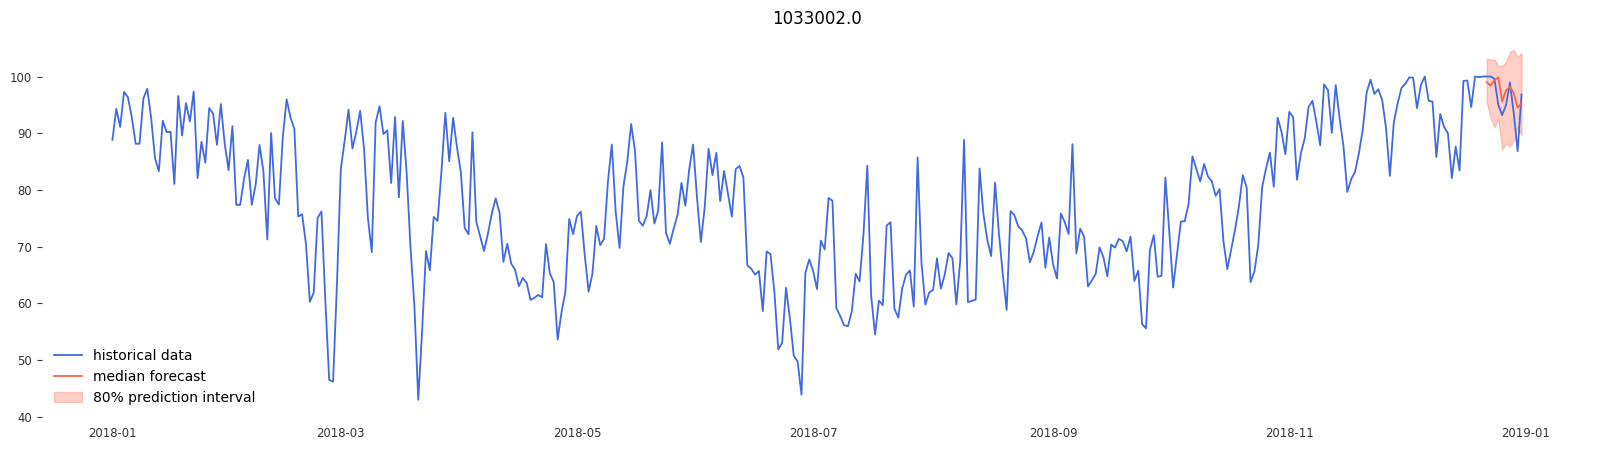

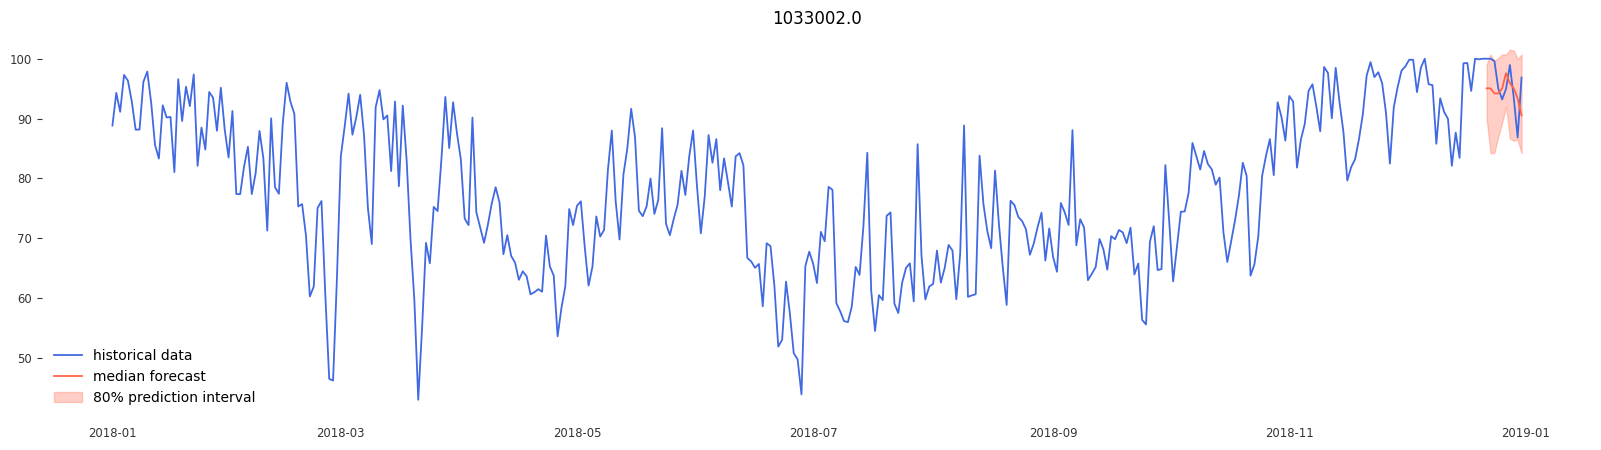

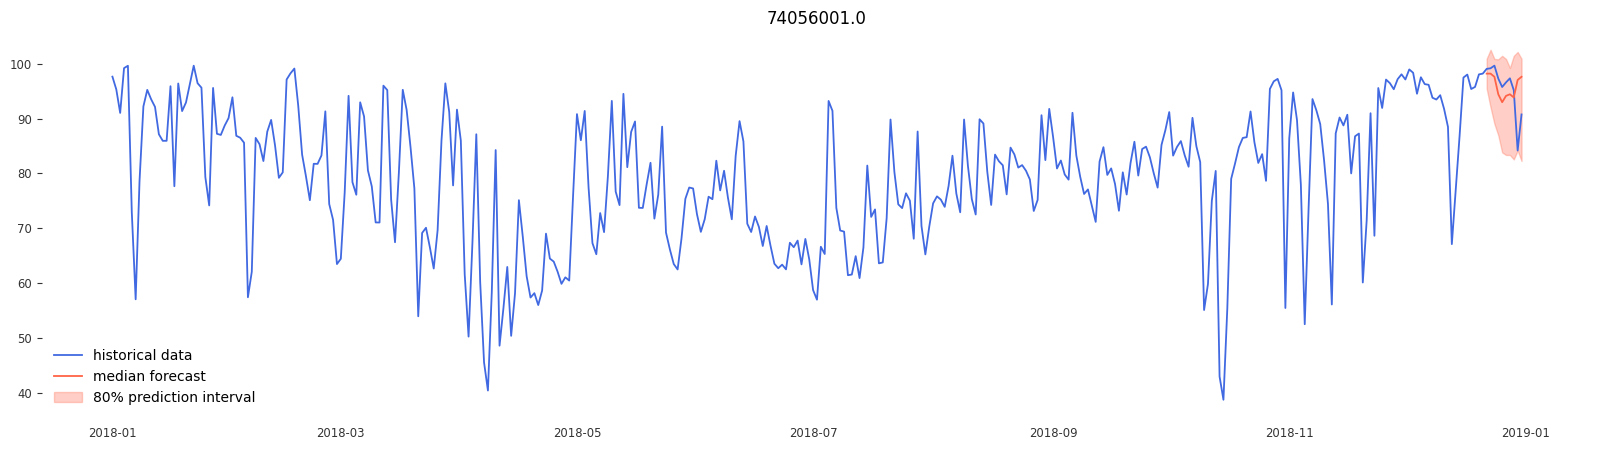

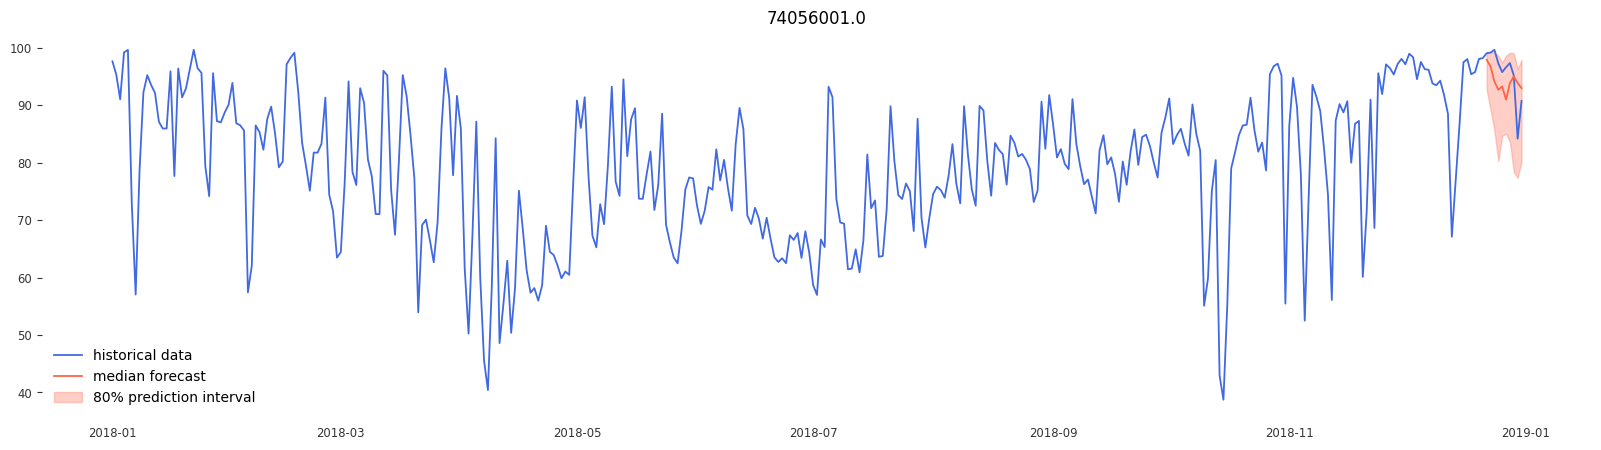

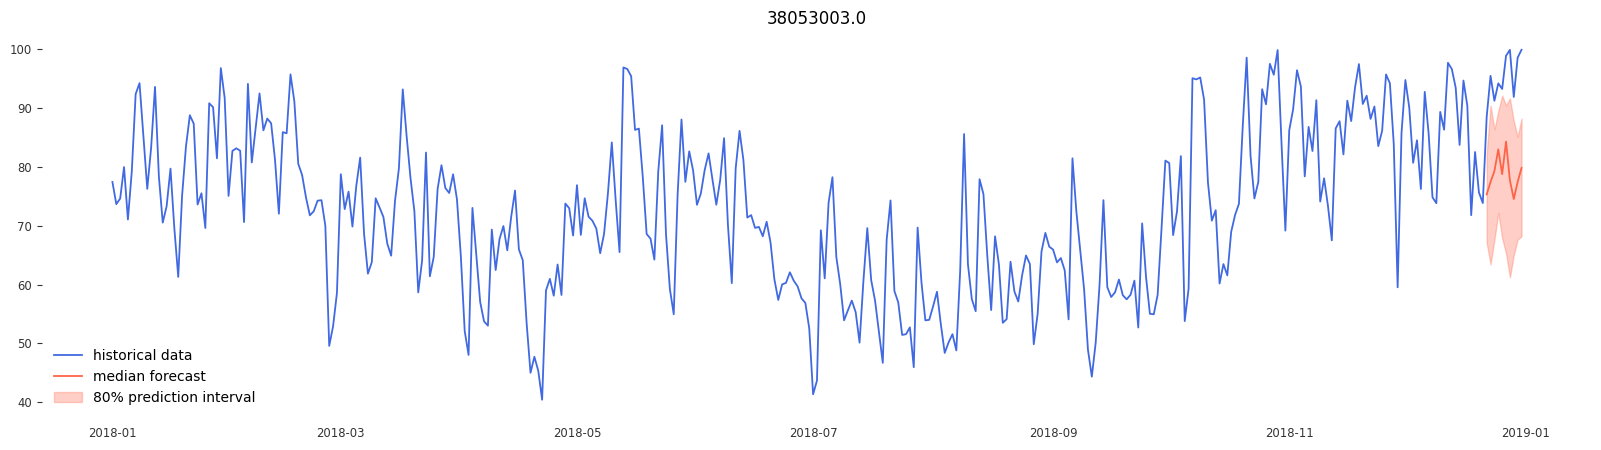

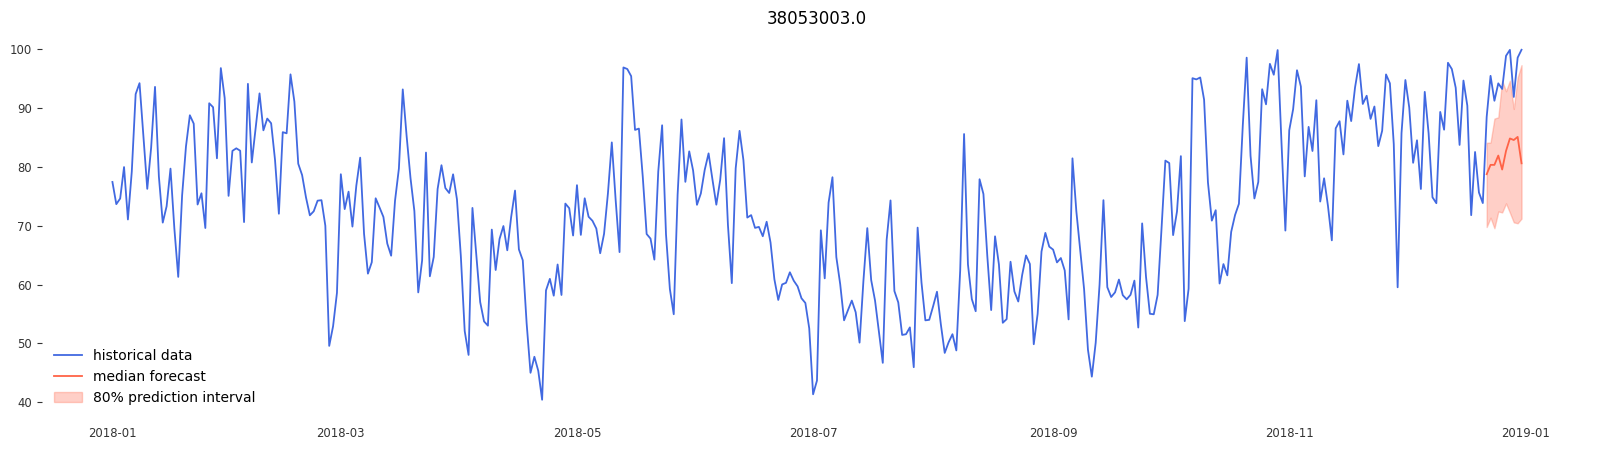

In [25]:
# get series ordered by volume in a descending way
series = test.groupby('unique_id')[TARGET].sum().reset_index().sort_values(by=TARGET, ascending=False)['unique_id'].tolist()

for ts in series[:3]:
    utils_meteo.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_tiny[forecast_tiny["unique_id"] == ts], ts, TARGET)
    utils_meteo.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_large[forecast_large["unique_id"] == ts], ts, TARGET)

In [23]:
df.head()

,date,unique_id,t
0,2018-01-01,1027003.0,280.587917
1,2018-01-02,1027003.0,280.189583
2,2018-01-03,1027003.0,282.273333
3,2018-01-04,1027003.0,282.673333
4,2018-01-05,1027003.0,284.290833


In [25]:
forecast_tiny.head()

,number_sta,date,forecast_lower,forecast,forecast_upper
355,1027003.0,2018-12-22,281.912445,284.016266,286.120087
356,1027003.0,2018-12-23,281.491681,284.016266,286.330469
357,1027003.0,2018-12-24,279.598242,281.912445,286.120087
358,1027003.0,2018-12-25,277.494421,281.912445,286.330469
359,1027003.0,2018-12-26,277.704803,281.912445,286.120087


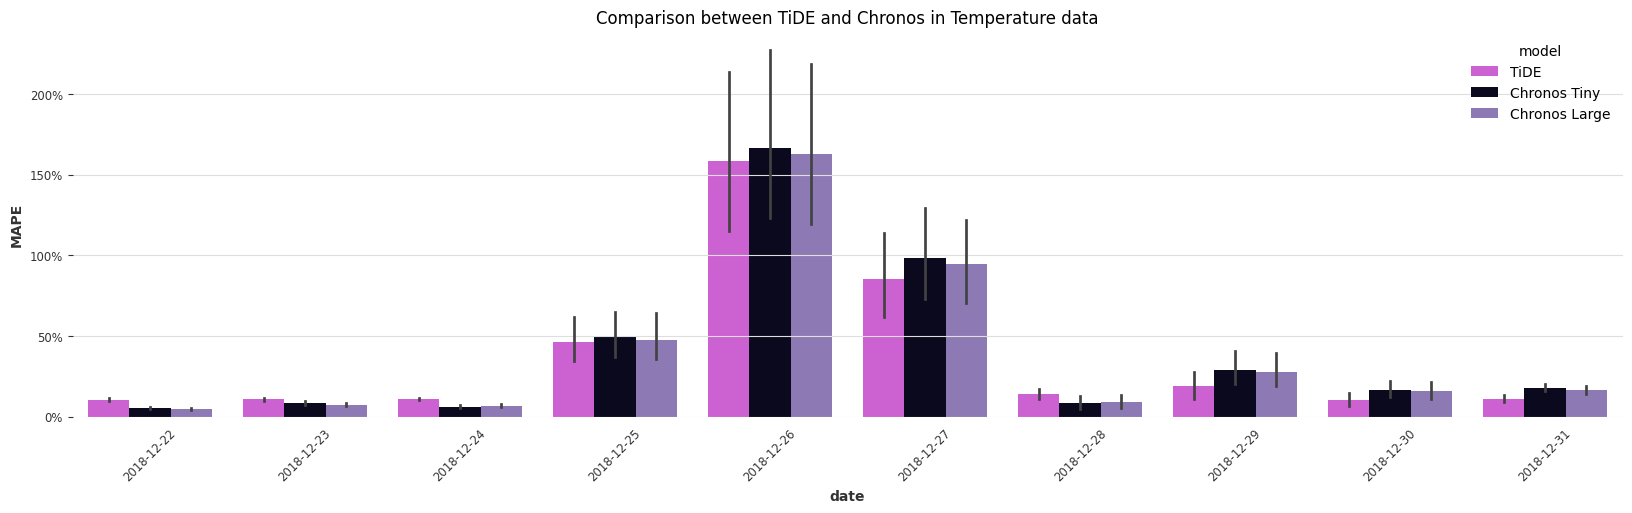

In [28]:
# load the forecast from our current model in production
# tide_model_df = pd.read_csv('data/tide.csv', parse_dates=['Date'])
# chronos_tiny_df = pd.read_csv('data/chronos_tiny.csv', parse_dates=['Date'])
# chronos_large_df = pd.read_csv('data/chronos_large.csv', parse_dates=['Date'])
tide_model_df = tide_forecast.copy()
chronos_tiny_df = forecast_tiny.copy()
chronos_large_df = forecast_large.copy()
tide_model_df.rename(columns={'forecast': 'TiDE'}, inplace=True)
chronos_tiny_df.rename(columns={'forecast': 'Chronos Tiny'}, inplace=True)
chronos_large_df.rename(columns={'forecast': 'Chronos Large'}, inplace=True)

# merge data frames with forecast and actuals
model_eval_df = pd.merge(test[['unique_id', 'date', TARGET]], tide_model_df[['unique_id', 'date', 'TiDE']], on=['unique_id', 'date'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_tiny_df[['unique_id', 'date', 'Chronos Tiny']], on=['unique_id', 'date'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', 'date', 'Chronos Large']], on=['unique_id', 'date'], how='inner')

# check performance for top 100 series
top_100 = df.groupby(['unique_id']).agg({TARGET: 'sum'}).reset_index().sort_values(by=TARGET, ascending=False).head(100)

utils_meteo.plot_model_comparison(model_eval_df[model_eval_df['unique_id'].isin(top_100['unique_id'])], TARGET)

# Tokinization with chronos

In [2]:
import pandas as pd
import torch
from chronos import ChronosPipeline, ChronosTokenizer, MeanScaleUniformBins, ChronosConfig

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
embeddings, tokenizer_state = pipeline.embed(context)

In [2]:
context

tensor([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115, 126,
        141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150, 178, 163,
        172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193, 181, 183, 218,
        230, 242, 209, 191, 172, 194, 196, 196, 236, 235, 229, 243, 264, 272,
        237, 211, 180, 201, 204, 188, 235, 227, 234, 264, 302, 293, 259, 229,
        203, 229, 242, 233, 267, 269, 270, 315, 364, 347, 312, 274, 237, 278,
        284, 277, 317, 313, 318, 374, 413, 405, 355, 306, 271, 306, 315, 301,
        356, 348, 355, 422, 465, 467, 404, 347, 305, 336, 340, 318, 362, 348,
        363, 435, 491, 505, 404, 359, 310, 337, 360, 342, 406, 396, 420, 472,
        548, 559, 463, 407, 362, 405, 417, 391, 419, 461, 472, 535, 622, 606,
        508, 461, 390, 432])

In [3]:
embeddings

tensor([[[ 0.0408,  0.0234,  0.0098,  ...,  0.0152,  0.0237, -0.0018],
         [ 0.0298, -0.0311,  0.0381,  ...,  0.0347,  0.0178, -0.0017],
         [-0.0240,  0.0165,  0.0408,  ...,  0.0488,  0.0054,  0.0200],
         ...,
         [ 0.0566,  0.0229,  0.0065,  ..., -0.1074,  0.0010, -0.0070],
         [-0.0325, -0.0325, -0.0060,  ..., -0.0718, -0.0033,  0.0277],
         [ 0.0072,  0.0173, -0.0176,  ..., -0.0034, -0.0121,  0.0306]]],
       dtype=torch.bfloat16)

In [4]:
tokenizer_state

tensor([280.2986])

In [3]:
n_numerical_tokens = 5
n_special_tokens = 2
use_eos_token = False
n_tokens = n_numerical_tokens + n_special_tokens
context_length = 3

config = ChronosConfig(
    tokenizer_class="MeanScaleUniformBins",
    tokenizer_kwargs=dict(low_limit=-1.0, high_limit=1.0),
    n_tokens=n_tokens,
    n_special_tokens=n_special_tokens,
    pad_token_id=0,
    eos_token_id=1,
    use_eos_token=use_eos_token,
    model_type="seq2seq",
    context_length=512,
    prediction_length=64,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
)

tokenizer = config.create_tokenizer()

context = torch.tensor(
        [
            [-3.7, 3.7],
            [-42.0, 42.0],
        ]
    )
batch_size, _ = context.shape

token_ids, attention_mask, scale = tokenizer.input_transform(context)

In [26]:
centers = torch.linspace(
            -1,
            1,
            config.n_tokens - config.n_special_tokens - 1,
        )

In [27]:
centers

tensor([-1.0000, -0.3333,  0.3333,  1.0000])

In [30]:
boundaries = torch.concat(
            (
                torch.tensor([-1e20]),
                (centers[1:] + centers[:-1]) / 2,
                torch.tensor([1e20]),
            )
        )

In [33]:
(centers[1:] + centers[:-1]) / 2

tensor([-0.6667,  0.0000,  0.6667])

In [31]:
boundaries

tensor([-1.0000e+20, -6.6667e-01,  0.0000e+00,  6.6667e-01,  1.0000e+20])

In [28]:
config.n_tokens - config.n_special_tokens - 1

4

In [4]:
token_ids, attention_mask, scale 

(tensor([[3, 6],
         [3, 6]]),
 tensor([[True, True],
         [True, True]]),
 tensor([ 3.7000, 42.0000]))

In [24]:
n_tokens

7

In [5]:
context.shape

torch.Size([2, 2])

In [6]:
attention_mask = ~torch.isnan(context)

In [7]:
attention_mask

tensor([[True, True],
        [True, True]])

In [8]:
torch.isnan(context)

tensor([[False, False],
        [False, False]])

In [11]:
scale = torch.nansum(
            torch.abs(context) * attention_mask, dim=-1
        ) / torch.nansum(attention_mask, dim=-1)

In [12]:
scale

tensor([ 3.7000, 42.0000])

In [13]:
torch.nansum(
            torch.abs(context) * attention_mask, dim=-1
        )

tensor([ 7.4000, 84.0000])

In [14]:
torch.abs(context) * attention_mask

tensor([[ 3.7000,  3.7000],
        [42.0000, 42.0000]])

In [15]:
torch.nansum(attention_mask, dim=-1)

tensor([2, 2])

In [16]:
scale[~(scale > 0)] = 1.0
scaled_context = context / scale.unsqueeze(dim=-1)

In [17]:
scale

tensor([ 3.7000, 42.0000])

In [18]:
scaled_context

tensor([[-1.,  1.],
        [-1.,  1.]])

In [19]:
scale.unsqueeze(dim=-1)

tensor([[ 3.7000],
        [42.0000]])

In [21]:
boundaries = torch.tensor([1, 3, 5, 7, 9])
v = torch.tensor([[3, 6, 9], [3, 6, 9]])

In [22]:
torch.bucketize(v, boundaries)

tensor([[1, 3, 4],
        [1, 3, 4]])

In [23]:
torch.bucketize(v, boundaries, right=True)

tensor([[2, 3, 5],
        [2, 3, 5]])

In [2]:
import warnings
warnings.filterwarnings('ignore')
# load model
pipeline_tiny = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

In [25]:
config_args = pipeline_tiny.model.model.config.chronos_config

In [26]:
config = ChronosConfig(**config_args)


In [52]:
tokenizer = config.create_tokenizer()

context = torch.tensor(df["t"].tolist()).unsqueeze(0)
batch_size, _ = context.shape

token_ids, attention_mask, scale = tokenizer.input_transform(context)

In [53]:
len(torch.unique(token_ids))

15

In [44]:
a.shape

torch.Size([1, 182692])

In [4]:
config_args = pipeline.model.model.config.chronos_config

In [5]:
config_args

{'tokenizer_class': 'MeanScaleUniformBins',
 'tokenizer_kwargs': {'low_limit': -15.0, 'high_limit': 15.0},
 'n_tokens': 4096,
 'n_special_tokens': 2,
 'pad_token_id': 0,
 'eos_token_id': 1,
 'use_eos_token': True,
 'model_type': 'seq2seq',
 'context_length': 512,
 'prediction_length': 64,
 'num_samples': 20,
 'temperature': 1.0,
 'top_k': 50,
 'top_p': 1.0}

In [2]:
# load data and exogenous features
path = "/mnt/data1/Datasets/Multimodal_v2/ts-data/french_weather/"
df = pd.read_csv(path + "pierre_expert_pandas.csv")

In [3]:
df.head()

,date,image_type,file_path
0,2017-12-08T16:00:00,IR039,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
1,2017-03-25T00:00:00,IR039,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
2,2018-11-02T05:00:00,IR039,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
3,2016-07-06T18:00:00,IR039,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
4,2017-04-19T07:00:00,IR039,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...


In [4]:
df.shape

(892649, 3)

In [6]:
df["image_type"].unique()

array(['IR039', 'VIS', 'CT', 'rainfall', 'WV', 'reflectivity_new',
       'reflectivity_old'], dtype=object)

In [13]:
df = df.sort_values(by=['date',"image_type"], ascending=[True, False])

In [14]:
df.head(10)

,date,image_type,file_path
769848,2016-01-01 00:00:00,reflectivity_old,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
442030,2016-01-01 00:00:00,rainfall,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
800666,2016-01-01 00:05:00,reflectivity_old,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
289329,2016-01-01 00:05:00,rainfall,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
677512,2016-01-01 00:10:00,reflectivity_old,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
401663,2016-01-01 00:10:00,rainfall,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
645248,2016-01-01 00:15:00,reflectivity_old,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
216743,2016-01-01 00:15:00,rainfall,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
882308,2016-01-01 00:20:00,reflectivity_old,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...
311411,2016-01-01 00:20:00,rainfall,/mnt/data2/Data_Pierre2/METEO_FRANCE/MAPS/extr...


In [15]:
data = pd.read_csv(path + "every6m-data2018.csv")
# df = pd.DataFrame(load_dataset("zaai-ai/time_series_datasets", data_files={'train': 'data.csv'})['train']).drop(columns=['Unnamed: 0'])
data[TIME_COL] = pd.to_datetime(data[TIME_COL])

In [16]:
data.shape

(43308315, 9)

In [17]:
data.head()

,date,number_sta,dd,ff,precip,hu,td,t,psl
0,2018-01-01,1027003,NaN,NaN,NaN,90.0,279.15,280.65,NaN
1,2018-01-01,1033002,30.0,2.7,0.2,89.0,277.65,279.35,NaN
2,2018-01-01,1034004,190.0,1.4,0.0,86.0,278.25,280.45,NaN
3,2018-01-01,1072001,NaN,NaN,0.0,NaN,NaN,280.25,NaN
4,2018-01-01,1089001,130.0,1.3,0.0,94.0,279.75,280.65,101760.0


In [18]:
dt=data.query("number_sta==1027003")

In [19]:
dt.head()

,date,number_sta,dd,ff,precip,hu,td,t,psl
0,2018-01-01 00:00:00,1027003,NaN,NaN,NaN,90.0,279.15,280.65,NaN
482,2018-01-01 00:06:00,1027003,NaN,NaN,NaN,92.0,279.45,280.65,NaN
964,2018-01-01 00:12:00,1027003,NaN,NaN,NaN,92.0,279.35,280.55,NaN
1446,2018-01-01 00:18:00,1027003,NaN,NaN,NaN,93.0,279.35,280.45,NaN
1928,2018-01-01 00:24:00,1027003,NaN,NaN,NaN,92.0,279.15,280.35,NaN


In [20]:
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
    'datetime': ['2023-04-29 09:00:00', '2023-04-29 10:30:00', '2023-04-29 12:45:00', '2023-04-29 15:00:00', '2023-04-29 18:15:00'],
    'value': [10, 20, 30, 40, 50]
})

# Convert the 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the DataFrame by hour
hour = 12
filtered_df = df[df['datetime'].dt.minutes == hour]

print(filtered_df)


             datetime  value
2 2023-04-29 12:45:00     30


In [22]:
df['datetime'].dt.minute

0     0
1    30
2    45
3     0
4    15
Name: datetime, dtype: int32

In [23]:
meteo_data = []
path = "/mnt/data1/Datasets/Multimodal_v2/ts-data/french_weather/"
for dat in [2016, 2017, 2018]:
    filename = "every6m-data" + str(dat) + ".csv"
    df = pd.read_csv(path + filename)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL])
    filtered_df = df[df['date'].dt.minute == 0]
    meteo_data.append(filtered_df)

df_all = pd.concat(meteo_data, ignore_index=True)

In [24]:
df_all.head()

,date,number_sta,dd,ff,precip,hu,td,t,psl
0,2016-01-01,1027003,NaN,NaN,NaN,98.0,278.75,279.05,NaN
1,2016-01-01,1033002,0.0,0.0,0.0,99.0,278.25,278.35,NaN
2,2016-01-01,1034004,0.0,0.0,0.0,100.0,279.15,279.15,NaN
3,2016-01-01,1072001,NaN,NaN,0.0,NaN,NaN,276.55,NaN
4,2016-01-01,1089001,0.0,0.0,0.0,95.0,278.85,279.55,102720.0


In [25]:
df_all.shape

(12739656, 9)